In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
import time

import re
import os
import os.path
import glob
from PIL import Image
from skimage import io

from sklearn.model_selection import StratifiedKFold                              
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from keras.utils import np_utils

from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from vis.utils import utils
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from vis.visualization import visualize_cam,visualize_saliency,overlay
from keras import activations

# Disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in image.list_pictures(list_fams[i], ext='jpg|jpeg|bmp|png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [5]:
# Creating base model (VGG16 convolutional layers)
image_shape = (224, 224, 3)                                                                                                                                               
weights='weights-malimg-xception-Adam-100epochs-fromscratch.h5'
model = Xception(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.load_weights(weights)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 111, 111, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 111, 111, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 111, 111, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# https://github.com/raghakot/keras-vis/issues/53
# "You need to specify penultimate_layer_idx in this case.
# By default, it will use the AveragePooling layer which does not have any spatial resolution.
# Try using the layer above it which has a (7, 7) resolution."
penultimate_layer_idx = utils.find_layer_idx(model, 'block14_sepconv2_act')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Family: Adialer.C
Image: ['07415497fc75ecf2e95f2bc64c9e326d.png'] - Class: ['Adialer.C'] - Pred: 0 (Adialer.C) - Prob: 23.99
Image: ['088fa7c16b4a1110f229992ea815e8e2.png'] - Class: ['Adialer.C'] - Pred: 0 (Adialer.C) - Prob: 23.17
Image: ['062a3381d1340ce4f67ad46e13fdcfdf.png'] - Class: ['Adialer.C'] - Pred: 0 (Adialer.C) - Prob: 23.17
Image: ['03c65e4528f100e6961470bb15843680.png'] - Class: ['Adialer.C'] - Pred: 0 (Adialer.C) - Prob: 22.19
Image: ['06d931db1678f133a58a3b29603e72f9.png'] - Class: ['Adialer.C'] - Pred: 0 (Adialer.C) - Prob: 23.80
Image: ['07cb2f5080dc3fc30ac06cbc4f117301.png'] - Class: ['Adialer.C'] - Pred: 0 (Adialer.C) - Prob: 22.27
Image: ['05470e5a35272f1ae45976054f925c7e.png'] - Class: ['Adialer.C'] - Pred: 0 (Adialer.C) - Prob: 23.99
Image: ['018066f21bc00a3f0c0477db13511a5f.png'] - Class: ['Adialer.C'] - Pred: 0 (Adialer.C) - Prob: 21.74
Image: ['0408a9a2ceeff1fba7cffe155d074d86.png'] - Class: ['Adialer.C'] - Pred: 0 (Adialer.C) - Prob: 21.09
Image: ['0389aa150d

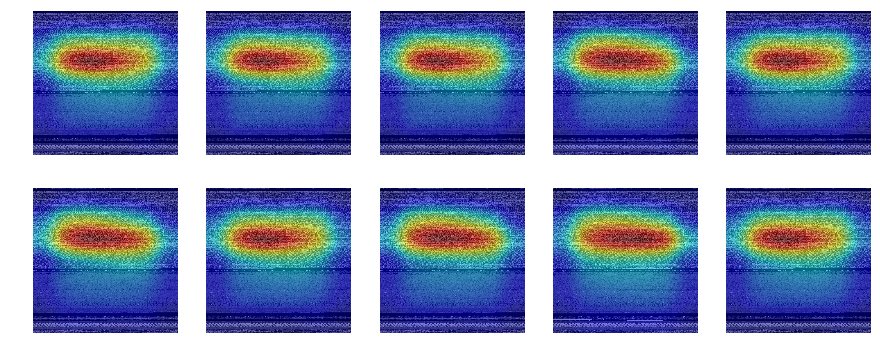

Family: Agent.FYI
Image: ['0095a73b6d04a452e6956e455d3b3229.png'] - Class: ['Agent.FYI'] - Pred: 1 (Agent.FYI) - Prob: 29.24
Image: ['0045a824dc491a2569fd1564140522c6.png'] - Class: ['Agent.FYI'] - Pred: 1 (Agent.FYI) - Prob: 23.45
Image: ['0002c75d65724084ec4e30695248f44b.png'] - Class: ['Agent.FYI'] - Pred: 1 (Agent.FYI) - Prob: 26.65
Image: ['009e7574b74d409c82bed74eb41f1c78.png'] - Class: ['Agent.FYI'] - Pred: 1 (Agent.FYI) - Prob: 28.38
Image: ['0050d50c12a61ba4d96af715e43cc063.png'] - Class: ['Agent.FYI'] - Pred: 1 (Agent.FYI) - Prob: 29.29
Image: ['039107be5aa223a3331b3d45fe2bc839.png'] - Class: ['Agent.FYI'] - Pred: 1 (Agent.FYI) - Prob: 27.65
Image: ['083423a50ddb6dad208b70820eaa9aae.png'] - Class: ['Agent.FYI'] - Pred: 1 (Agent.FYI) - Prob: 21.00
Image: ['002bb62e80912094ff9835005d904ce1.png'] - Class: ['Agent.FYI'] - Pred: 1 (Agent.FYI) - Prob: 20.56
Image: ['00275a24e433a32333315022c5e1b520.png'] - Class: ['Agent.FYI'] - Pred: 1 (Agent.FYI) - Prob: 26.45
Image: ['00b4f405f2

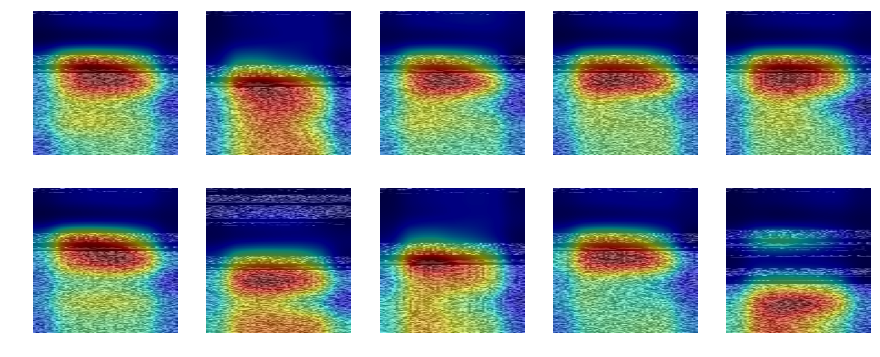

Family: Allaple.A
Image: ['03a4ac32db3470629c54d0a9472ec111.png'] - Class: ['Allaple.A'] - Pred: 2 (Allaple.A) - Prob: 22.65
Image: ['082c34d8429258bdbb998730fd1bf676.png'] - Class: ['Allaple.A'] - Pred: 2 (Allaple.A) - Prob: 26.55
Image: ['07ea613426d2723d294515fec791c3a9.png'] - Class: ['Allaple.A'] - Pred: 2 (Allaple.A) - Prob: 27.76
Image: ['04cb4c9e3f08602a0c38b6f987d3abe4.png'] - Class: ['Allaple.A'] - Pred: 2 (Allaple.A) - Prob: 25.64
Image: ['00be1e0827187dc5cd44f9f949c80376.png'] - Class: ['Allaple.A'] - Pred: 2 (Allaple.A) - Prob: 24.50
Image: ['077d331719a171d70651832899fdc920.png'] - Class: ['Allaple.A'] - Pred: 2 (Allaple.A) - Prob: 25.57
Image: ['00b6ca3f16f819d97565b08ad306ad41.png'] - Class: ['Allaple.A'] - Pred: 2 (Allaple.A) - Prob: 25.23
Image: ['00954b327eddda13b4a3bcf527a4129f.png'] - Class: ['Allaple.A'] - Pred: 2 (Allaple.A) - Prob: 15.92
Image: ['085e7ed069573e6bd8166c08bff850c7.png'] - Class: ['Allaple.A'] - Pred: 2 (Allaple.A) - Prob: 23.33
Image: ['082ff4d1ba

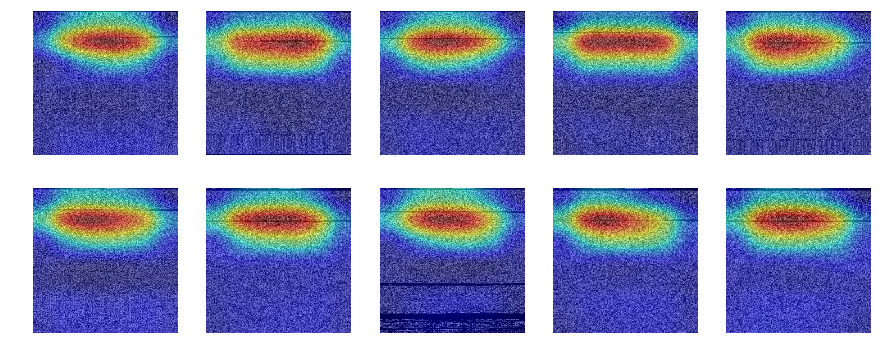

Family: Allaple.L
Image: ['0349b9ddea5e67906d2427509d916b41.png'] - Class: ['Allaple.L'] - Pred: 3 (Allaple.L) - Prob: 33.51
Image: ['014a4d972383915e749b691bb0cba00e.png'] - Class: ['Allaple.L'] - Pred: 3 (Allaple.L) - Prob: 38.70
Image: ['007614dd7c0f284ba0a1e44f9dfdf5db.png'] - Class: ['Allaple.L'] - Pred: 3 (Allaple.L) - Prob: 34.68
Image: ['04db81b6f016a4c85d21b5367cb5cd72.png'] - Class: ['Allaple.L'] - Pred: 3 (Allaple.L) - Prob: 43.75
Image: ['006c4777876cd17a853d30aa75f3bd59.png'] - Class: ['Allaple.L'] - Pred: 3 (Allaple.L) - Prob: 37.77
Image: ['006253e75255a84fd95e36f1f2a421bb.png'] - Class: ['Allaple.L'] - Pred: 3 (Allaple.L) - Prob: 35.29
Image: ['0397dc1f0141f959713d73c3e8b1d17a.png'] - Class: ['Allaple.L'] - Pred: 3 (Allaple.L) - Prob: 40.04
Image: ['076cded916ce4790e259bd8b57d24737.png'] - Class: ['Allaple.L'] - Pred: 3 (Allaple.L) - Prob: 33.21
Image: ['0575bc3f48c2118edb273c6d6592c9aa.png'] - Class: ['Allaple.L'] - Pred: 3 (Allaple.L) - Prob: 33.93
Image: ['032e508781

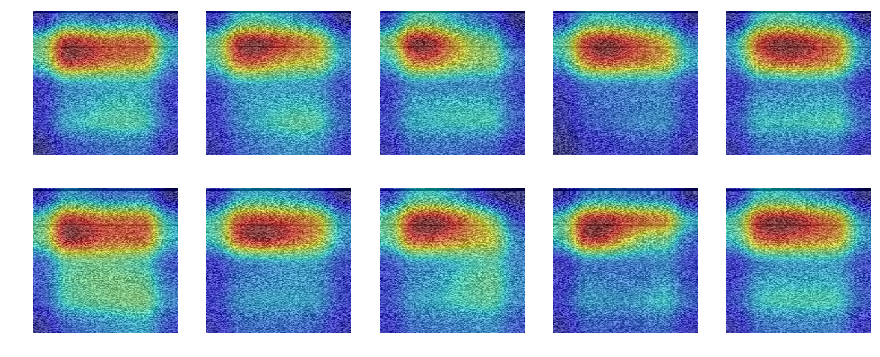

Family: Alueron.gen!J
Image: ['0172039835f86ac5d8180a698d98494e.png'] - Class: ['Alueron.gen!J'] - Pred: 4 (Alueron.gen!J) - Prob: 19.09
Image: ['000c6b259c07b2197f163a6e0f97cd89.png'] - Class: ['Alueron.gen!J'] - Pred: 4 (Alueron.gen!J) - Prob: 17.78
Image: ['006d4096fd2a9330e5e3903697fef6fa.png'] - Class: ['Alueron.gen!J'] - Pred: 4 (Alueron.gen!J) - Prob: 19.61
Image: ['067577ad5009dcdfc466a15db3f9a1cc.png'] - Class: ['Alueron.gen!J'] - Pred: 4 (Alueron.gen!J) - Prob: 21.59
Image: ['06b1e646130394aced3c030ea28a5720.png'] - Class: ['Alueron.gen!J'] - Pred: 4 (Alueron.gen!J) - Prob: 18.69
Image: ['0745a9007d10991e6cdd421bee8c5f6b.png'] - Class: ['Alueron.gen!J'] - Pred: 4 (Alueron.gen!J) - Prob: 21.44
Image: ['07d18c02d06498b94fdee8ca9ffb70c0.png'] - Class: ['Alueron.gen!J'] - Pred: 4 (Alueron.gen!J) - Prob: 18.28
Image: ['00cf3cec39a19139d6c4416afe7d9c8a.png'] - Class: ['Alueron.gen!J'] - Pred: 4 (Alueron.gen!J) - Prob: 19.66
Image: ['0447f6b81f7a9c23b08d7ae6f115c83a.png'] - Class: [

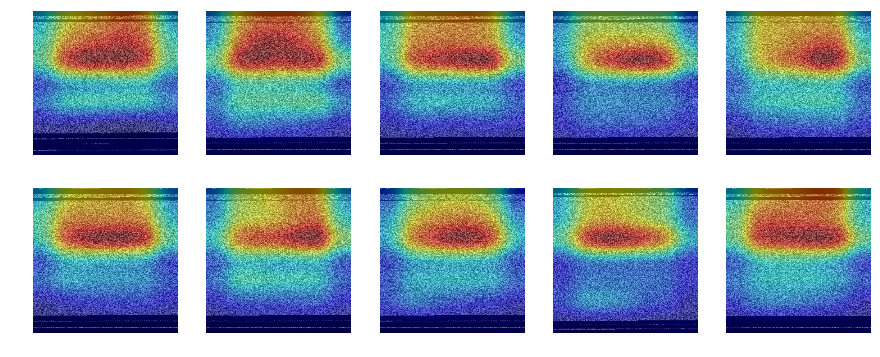

Family: Autorun.K
Image: ['0516a02eaca930cdf6fa22ea705ae246.png'] - Class: ['Autorun.K'] - Pred: 5 (Autorun.K) - Prob: 11.75
Image: ['07eb7bdf5c920193d55bf1bd45e9b7cd.png'] - Class: ['Autorun.K'] - Pred: 5 (Autorun.K) - Prob: 11.75
Image: ['01158999b9844bd2c24fa7f95b7a0c27.png'] - Class: ['Autorun.K'] - Pred: 5 (Autorun.K) - Prob: 11.75
Image: ['0605fe41b967cc179bd19bdabb6db6e9.png'] - Class: ['Autorun.K'] - Pred: 5 (Autorun.K) - Prob: 11.75
Image: ['03d8427c6cfd554d0e8ce33c67147ee3.png'] - Class: ['Autorun.K'] - Pred: 5 (Autorun.K) - Prob: 11.75
Image: ['017ddf67021a357908d693545b92a68b.png'] - Class: ['Autorun.K'] - Pred: 5 (Autorun.K) - Prob: 11.75
Image: ['00a53b82a0ebbbea57289e26000f95ba.png'] - Class: ['Autorun.K'] - Pred: 5 (Autorun.K) - Prob: 11.75
Image: ['053e84dd4fe04a5584116c892363dca4.png'] - Class: ['Autorun.K'] - Pred: 5 (Autorun.K) - Prob: 11.75
Image: ['00aad43545abcab69c3d53bca4bce847.png'] - Class: ['Autorun.K'] - Pred: 5 (Autorun.K) - Prob: 11.75
Image: ['063f9b6d52

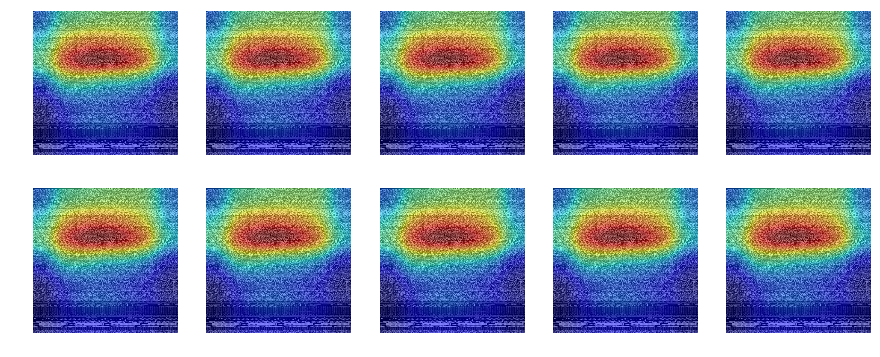

Family: C2LOP.gen!g
Image: ['06d93637d01e31853906221362203319.png'] - Class: ['C2LOP.gen!g'] - Pred: 6 (C2LOP.gen!g) - Prob: 22.21
Image: ['073897d668356d8ed61f1b2a29bef1e6.png'] - Class: ['C2LOP.gen!g'] - Pred: 6 (C2LOP.gen!g) - Prob: 20.10
Image: ['0853bbcf651699d5cdad8ac9418708d8.png'] - Class: ['C2LOP.gen!g'] - Pred: 6 (C2LOP.gen!g) - Prob: 19.98
Image: ['0776ced607b2d9764e226fc45e7c109e.png'] - Class: ['C2LOP.gen!g'] - Pred: 6 (C2LOP.gen!g) - Prob: 21.41
Image: ['06ba5c06f8a6b13ae0eccc12a19f0ec4.png'] - Class: ['C2LOP.gen!g'] - Pred: 6 (C2LOP.gen!g) - Prob: 25.32
Image: ['002032ec547485f9874701bacc4efff6.png'] - Class: ['C2LOP.gen!g'] - Pred: 6 (C2LOP.gen!g) - Prob: 24.50
Image: ['01c47904124b6df3d1db012c106f27d1.png'] - Class: ['C2LOP.gen!g'] - Pred: 6 (C2LOP.gen!g) - Prob: 17.53
Image: ['031ecca0a0d3b555fd6e4d6ee14e9714.png'] - Class: ['C2LOP.gen!g'] - Pred: 6 (C2LOP.gen!g) - Prob: 16.14
Image: ['077f77e731ff65728ddee4fa6227d639.png'] - Class: ['C2LOP.gen!g'] - Pred: 6 (C2LOP.ge

In [ ]:
samplesbyfamily = 10
samplesbyrow = 5
for fam in list_fams:
    print("Family: %s" %(fam))
    fam_samples = [name for name in list_paths if fam in name]
    image_paths = random.sample(fam_samples, samplesbyfamily)
    
    #fig = plt.figure(figsize=(16, 8))
    f, ax = plt.subplots(samplesbyfamily//samplesbyrow, samplesbyrow)
    f.set_size_inches(3*samplesbyrow, 3*(samplesbyfamily//samplesbyrow))
    ind = 0
    
    for path in image_paths:        
        img = io.imread(path)
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, (224, 224))
        img = image.img_to_array(img)
        
        x = image.load_img(path, target_size=(224, 224))
        x = image.img_to_array(x)
        x = preprocess_input(x)
        pred_class = np.argmax(model.predict(np.array([x])))
        pred_proba = np.amax(model.predict(np.array([x])))
        print("Image: %s - Class: %s - Pred: %d (%s) - Prob: %.2f" %(path.split('/')[-1:],path.split('/')[-2:-1],pred_class,list_fams[pred_class],pred_proba))
        
        heatmapguided = visualize_cam(model, layer_idx, filter_indices=[pred_class], seed_input=x, penultimate_layer_idx=penultimate_layer_idx)        
        
        ax[ind//samplesbyrow,ind%samplesbyrow].axis('off')
        ax[ind//samplesbyrow,ind%samplesbyrow].imshow(overlay(heatmapguided, img))
        ind = ind + 1
        
    plt.show()